In [350]:
#imports
import pandas as pd 
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [351]:
os.path.abspath(os.getcwd())

df_standards_warm = pd.read_csv("../data/standards_warm/Data_28_5__15_41_20_0_zu_2500.csv")  
df_warm_standards = pd.read_csv("../data/warm_standards_hamilton/Data_9_6__16_12_35_0_zu_2500.csv")

#todo ask what is valueRAW and what is value? my guess is that its the same data but just scaled somehow (see plot)


In [352]:
df_warm_standards.head

<bound method NDFrame.head of      Unnamed: 0.1  Unnamed: 0                     Time  ValueRAW       Value  \
0               0           0  2021-06-09 16:03:42.933     32347  1010.84375   
1               1           1  2021-06-09 16:03:43.456     32196  1006.12500   
2               2           2  2021-06-09 16:03:43.981     32167  1005.21875   
3               3           3  2021-06-09 16:03:44.505     32079  1002.46875   
4               4           4  2021-06-09 16:03:45.030     32075  1002.34375   
..            ...         ...                      ...       ...         ...   
995           995         995  2021-06-09 16:12:32.765     22073   689.78125   
996           996         996  2021-06-09 16:12:33.292     22067   689.59375   
997           997         997  2021-06-09 16:12:33.844     22067   689.59375   
998           998         998  2021-06-09 16:12:34.370     22073   689.78125   
999           999         999  2021-06-09 16:12:34.910     22074   689.81250   

     Real

In [353]:
df_standards_warm.head

<bound method NDFrame.head of      Unnamed: 0.1  Unnamed: 0                     Time  ValueRAW       Value  \
0               0           0  2021-05-28 15:32:29.972     32520  1016.25000   
1               1           1  2021-05-28 15:32:30.493     32335  1010.46875   
2               2           2  2021-05-28 15:32:31.029     32272  1008.50000   
3               3           3  2021-05-28 15:32:31.563     32259  1008.09375   
4               4           4  2021-05-28 15:32:32.085     32251  1007.84375   
..            ...         ...                      ...       ...         ...   
995           995         995  2021-05-28 15:41:17.913     23466   733.31250   
996           996         996  2021-05-28 15:41:18.438     23456   733.00000   
997           997         997  2021-05-28 15:41:18.978     23467   733.34375   
998           998         998  2021-05-28 15:41:19.503     23444   732.62500   
999           999         999  2021-05-28 15:41:20.029     23451   732.84375   

     Real

In [354]:
time = df_standards_warm["Time"]
values = df_standards_warm["Value"]
values_raw = df_standards_warm["ValueRAW"]

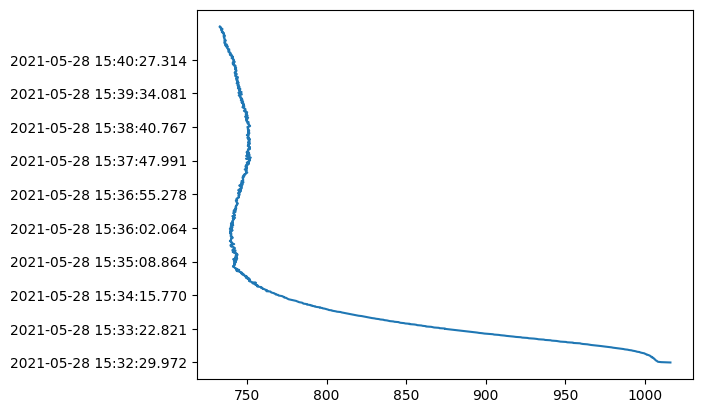

In [355]:
#plot time to values
plt.plot(values,time)
plt.yticks(range(0, len(time), 100))
plt.show()

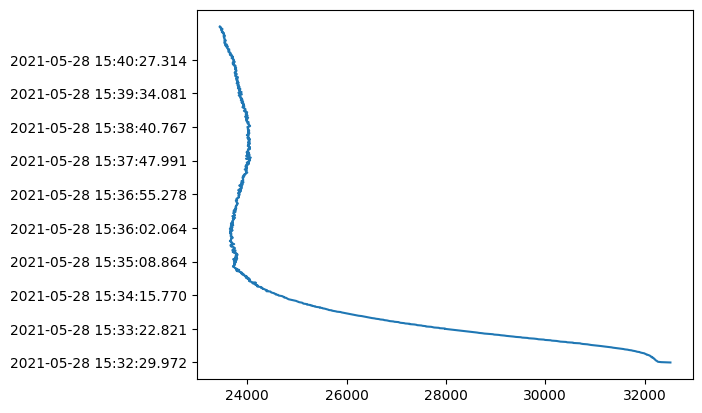

In [356]:
#plot time to valuesRAW

plt.plot(values_raw,time)
plt.yticks(range(0, len(time), 100))
plt.show()

In [357]:
#get data

with open("../data/data_max/value_target.csv", "w") as f:
    f.write("")

with open("../data/data_max/value_target.csv", "a") as f:
    header = "target"
    for i in range(1, 1001):
        header = header + ",value_" + str(i)
    f.write(header + "\n")

#iter over every file from a folder
for filename in os.listdir("../data/standards_warm/"):
    #open file
    df_standards_warm = pd.read_csv("../data/standards_warm/"+filename)  
    #get the number which appears at the end between _...csv
    number = filename.split("_")[-1].split(".")[0]
    #get the values from the column value
    values = df_standards_warm["Value"]
    #create a new file with the name data_max/file
    with open("../data/data_max/value_target.csv", "a") as f:
        #write the number which appears at the end between _...csv in a row of data/data_max/file
        f.write(number)
        #write a comma
        f.write(",")
        #write the values from the column value in a row of data/data_max/file
        f.write(",".join(str(x) for x in values))
        #write a new line
        f.write("\n")
        
#iter over every file from a folder
for filename in os.listdir("../data/warm_standards_hamilton"):
    #open file
    df_standards_warm = pd.read_csv("../data/warm_standards_hamilton/"+filename)  
    #get the number which appears at the end between _...csv
    number = filename.split("_")[-1].split(".")[0]
    #get the values from the column value
    values = df_standards_warm["Value"]
    #create a new file with the name data_max/file
    with open("../data/data_max/value_target.csv", "a") as f:
        #write the number which appears at the end between _...csv in a row of data/data_max/file
        f.write(number)
        #write a comma
        f.write(",")
        #write the values from the column value in a row of data/data_max/file
        f.write(",".join(str(x) for x in values))
        #write a new line
        f.write("\n")

In [358]:

df_value_target = pd.read_csv("../data/data_max/value_target.csv")

test = df_value_target.tail(3)


train = df_value_target.drop(df_value_target.tail(3).index)

test_x = test.drop("target", axis=1)

test_y = test["target"]

train_x = train.drop("target", axis=1)

train_y = train["target"]

#later for creating onnx file necessary
input_names = list(train_x)
output_names = list(train_y)

# Regression

In [359]:
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)

scalerX = StandardScaler().fit(train_x)
scalerY = StandardScaler().fit(train_y)
train_x = scalerX.transform(train_x)
train_y = scalerY.transform(train_y)
test_x = scalerX.transform(test_x)
test_y = scalerY.transform(test_y)

model = LinearRegression().fit(train_x, train_y)

predictions = model.predict(test_x)

#print(predictions)
print(test_y)
#convert tensor to numpy
test_y = np.array(test_y)

#calculate MAE 
mae = sum(abs(predictions - test_y))/len(predictions)
print(mae)

[[-0.57659812]
 [ 0.40415756]
 [ 2.50577689]]
[1.18856419]


# Simple Neural Network

In [360]:
test_x = pd.DataFrame(test_x)
test_y = pd.DataFrame(test_y)
train_x = pd.DataFrame(train_x)
train_y = pd.DataFrame(train_y)

#convert data to tensors
test_x = torch.tensor(test_x.to_numpy()).float()
test_y = torch.tensor(test_y.to_numpy()).float()
train_x = torch.tensor(train_x.to_numpy()).float()
train_y = torch.tensor(train_y.to_numpy()).float()

#create a simple neural network with pytroch
model = torch.nn.Sequential(
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 1)
)

criterion = torch.nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

for epoch in range(1000):
    y_pred = model(train_x)
    loss = criterion(y_pred, train_y.float())
    print("epoch: ", epoch, "loss: ", loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
#cacluate predictions
pred_y = model(test_x.float())


#calculate MAE
mae = sum(abs(pred_y - test_y))/len(pred_y)
#convert tensor to array 
mae = mae.detach().numpy()
print("MAE: " + str(mae[0]))

#rescale data
pred_y = scalerY.inverse_transform(pred_y.detach().numpy())
test_y = scalerY.inverse_transform(test_y.detach().numpy())

#print(pred_y)
#print(test_y)



epoch:  0 loss:  1.240156888961792
epoch:  1 loss:  27.199575424194336
epoch:  2 loss:  1.906610369682312
epoch:  3 loss:  1.0416181087493896
epoch:  4 loss:  0.721625804901123
epoch:  5 loss:  0.5908926129341125
epoch:  6 loss:  0.4217291474342346
epoch:  7 loss:  0.4989933669567108
epoch:  8 loss:  0.7403952479362488
epoch:  9 loss:  0.6717711687088013
epoch:  10 loss:  0.5656147003173828
epoch:  11 loss:  0.5926540493965149
epoch:  12 loss:  0.4146561324596405
epoch:  13 loss:  0.632722795009613
epoch:  14 loss:  0.48376724123954773
epoch:  15 loss:  0.6137675642967224
epoch:  16 loss:  0.4167497158050537
epoch:  17 loss:  0.5157238841056824
epoch:  18 loss:  0.43511489033699036
epoch:  19 loss:  0.5349529385566711
epoch:  20 loss:  0.45371901988983154
epoch:  21 loss:  0.44710424542427063
epoch:  22 loss:  0.4306375980377197
epoch:  23 loss:  0.4409235417842865
epoch:  24 loss:  0.4681985676288605
epoch:  25 loss:  0.4177462160587311
epoch:  26 loss:  0.4362853169441223
epoch:  27 

In [361]:
#visualize model structure with netron
model.eval()
input_names = ['Values']
output_names = ['Targets']

torch.onnx.export(model,
                  train_x, 
                  "../model_structure/simple_nn.onnx", 
                  input_names=input_names, 
                  output_names=output_names,
                  )
#for having directly and png in the folder someone could create code that an png gets created directly from the onnx file